<a href="https://colab.research.google.com/github/sazzad15-1779/machine-learning/blob/master/ViTLinformer_RIFAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install vit_pytorch linformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.3 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/xiaohong1/COVID-ViT.git


Cloning into 'COVID-ViT'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 143 (delta 4), reused 0 (delta 0), pack-reused 135
Receiving objects: 100% (143/143), 7.62 MiB | 5.75 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
%cd /content/COVID-ViT/vit_pytorch

/content/COVID-ViT/vit_pytorch


In [ ]:
%run vit_3D.py


In [ ]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as F
import io
import nibabel  # to read .hdr/.img files
import numpy
import numpy as np
from skimage.transform import resize
#from vit_pytorch.efficient import ViT
#from vit_pytorch import ViT
#from vit_pytorch.vit_3D import ViT3

from vit_pytorch.vit_3d import ViT

def resize2d(img, size):
    return F.adaptive_avg_pool2d(Variable(img),size).data

In [ ]:
class_labels=["0","1"]
#labels=["nonCovid"]
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
def fun_classification_report(target_test, y_pred):
  print('Classification Report')
  print(classification_report(target_test, y_pred, target_names=class_labels))

def fun_confusion_matrix(target_test, y_pred):

  cn=confusion_matrix(target_test, y_pred)
  df_cm = pd.DataFrame(cn, index = [i for i in class_labels],
                    columns = [i for i in class_labels])
  plt.figure(figsize = (5,3))
  sns.heatmap(df_cm, annot=True,fmt="d")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nibabel as nib

# Load the NIfTI file
filename = '/content/drive/MyDrive/Northwestern/Data/pulmonary/extracted_roi_138-L.nii'
nifti_img = nib.load(filename)

# Get the data shape
data_shape = nifti_img.shape

#There are 359 images (slices) with dimensions 382 x 251

print('Data shape:', data_shape)


Data shape: (382, 251, 359)


In [ ]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1+cu118


In [ ]:
# Training settings
batch_size = 4 # 64
epochs = 20 #40 #10   #20 #10 #50 #20
lr = 3e-5
gamma = 0.7
seed = 42 # 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import nibabel as nib
import glob
import os
import random
from shutil import copyfile

# Set the paths for your NumPy files and train/test directories
abnormal_labels_path = '/content/drive/MyDrive/Northwestern/npdata/abnormal_labels.npy'
abnormal_scans_path = '/content/drive/MyDrive/Northwestern/npdata/abnormal_scans.npy'
normal_labels_path = '/content/drive/MyDrive/Northwestern/npdata/normal_labels.npy'
normal_scans_path = '/content/drive/MyDrive/Northwestern/npdata/normal_scans.npy'
#train_dir = '/content/drive/MyDrive/Northwestern/Train'
#test_dir = '/content/drive/MyDrive/Northwestern/Test'

train_dir = '/content/Northwestern/Train'
test_dir = '/content/Northwestern/Test'

# Load the NumPy files
abnormal_labels = np.load(abnormal_labels_path)
abnormal_scans = np.load(abnormal_scans_path)
normal_labels = np.load(normal_labels_path)
normal_scans = np.load(normal_scans_path)

# Combine the data and labels into a single array
data = np.concatenate((abnormal_scans, normal_scans), axis=0)
labels = np.concatenate((abnormal_labels, normal_labels), axis=0)

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Shuffle the data and labels in unison
random.seed(42)  # Set the random seed for reproducibility
combined = list(zip(data, labels))
random.shuffle(combined)
data, labels = zip(*combined)

# Calculate the train-test split index
train_test_split = int(len(data) * 0.7)  # 70% train, 30% test





# Convert and save the data as HDR files
for i, (scan, label) in enumerate(zip(data, labels)):
    #print(label)
    # Crop the central region of the image
    crop_size = (min(scan.shape[0], scan.shape[1]), min(scan.shape[0], scan.shape[1]), min(scan.shape[2], 16))
    start_x = (scan.shape[0] - crop_size[0]) // 2
    start_y = (scan.shape[1] - crop_size[1]) // 2
    start_z = (scan.shape[2] - crop_size[2]) // 2
    end_x = start_x + crop_size[0]
    end_y = start_y + crop_size[1]
    end_z = start_z + crop_size[2]
    cropped_image = scan[start_x:end_x, start_y:end_y, start_z:end_z]

    # Resize the cropped image to the desired shape
    desired_shape = (224, 224, 16)
    reshaped_image = resize(cropped_image, desired_shape, anti_aliasing=True)

    # Add an extra dimension to match the (224, 224, 16, 1) shape
    reshaped_image = np.expand_dims(reshaped_image, axis=-1)

    hdr_image = nib.Nifti1Image(reshaped_image, affine=np.eye(4))
    filename = f'{i:04d}_{int(label)}.hdr'
    if i < train_test_split:
        output_dir = train_dir
    else:
        output_dir = test_dir
    output_path = os.path.join(output_dir, filename)
    nib.save(hdr_image, output_path)

# Copy the original NumPy files to the train and test directories
copyfile(abnormal_labels_path, os.path.join(train_dir, 'abnormal_labels.npy'))
copyfile(abnormal_scans_path, os.path.join(train_dir, 'abnormal_scans.npy'))
copyfile(normal_labels_path, os.path.join(train_dir, 'normal_labels.npy'))
copyfile(normal_scans_path, os.path.join(train_dir, 'normal_scans.npy'))
copyfile(abnormal_labels_path, os.path.join(test_dir, 'abnormal_labels.npy'))
copyfile(abnormal_scans_path, os.path.join(test_dir, 'abnormal_scans.npy'))
copyfile(normal_labels_path, os.path.join(test_dir, 'normal_labels.npy'))
copyfile(normal_scans_path, os.path.join(test_dir, 'normal_scans.npy'))



'/content/Northwestern/Test/normal_scans.npy'

In [ ]:
os.makedirs('data-3d', exist_ok=True)

In [ ]:
#train_dir = '/content/drive/MyDrive/Northwestern/Train'
#test_dir = '/content/drive/MyDrive/Northwestern/Test'

train_dir = '/content/Northwestern/Train'
test_dir = '/content/Northwestern/Test'

In [ ]:
train_list = glob.glob(os.path.join(train_dir,'*.hdr'))
test_list = glob.glob(os.path.join(test_dir, '*.hdr'))

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 193
Test Data: 83


ran-idx-list = [52 15 72 61 21 75 75 24  3]


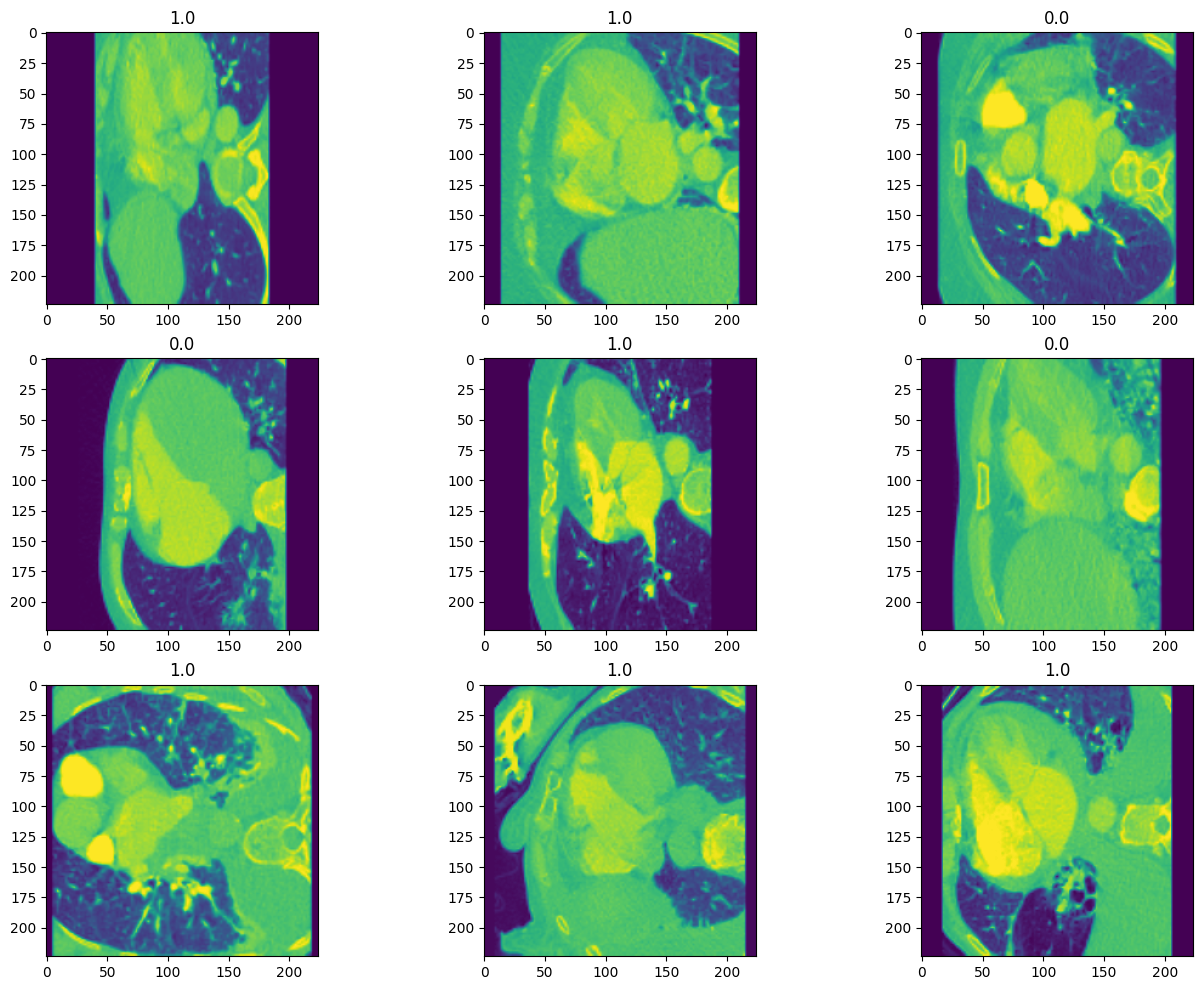

In [ ]:
#random_idx = np.random.randint(1, len(train_list), size=9)
random_idx = np.random.randint(1, len(test_list), size=9)
print('ran-idx-list =', random_idx)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    #img = Image.open(train_list[idx])
    #print(train_list[idx])
    img = nibabel.load(train_list[idx])
    #print(img.shape)
    img = numpy.asanyarray(img.dataobj) #struct.get_data()
    img = numpy.rot90(img)
    #print(labels[idx])
    ax.set_title(labels[idx])
    ax.imshow(img[:,:,1])

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have the train_list containing the image paths
#train_list = [...]

# Split the train_list into train and validation sets
train_list, valid_list = train_test_split(train_list, test_size=0.2, random_state=seed)

# Select a single item from train_list
item_index = 0
image_path = train_list[item_index]
print(image_path)
label = image_path.split("/")[-1].split("_")[-1]

# Load and inspect the image
img = nib.load(image_path)
image_size = img.shape

print("Image size:", image_size)
print("Label:", label)


/content/Northwestern/Train/0125_1.hdr
Image size: (224, 224, 16, 1)
Label: 1.hdr


In [ ]:
# from sklearn.model_selection import train_test_split

# # Assuming you have train_list and labels defined

# try:
#     train_list, valid_list, train_labels, valid_labels = train_test_split(train_list,
#                                                                           labels,
#                                                                           test_size=0.2,
#                                                                           stratify=labels,
#                                                                           random_state=seed)
# except ValueError:
#     print("Some classes have too few samples to perform stratified splitting.")
#     print("Attempting random splitting without stratification.")
#     train_list, valid_list, train_labels, valid_labels = train_test_split(train_list,
#                                                                           labels,
#                                                                           test_size=0.2,
#                                                                           random_state=seed)


In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 154
Validation Data: 39
Test Data: 83


In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transforms.ToTensor(),
    ]
)

In [ ]:
class CovidDataset_3D(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = nib.load(img_path)
        img = np.asanyarray(img.dataobj)

        img_transformed = torch.tensor(img)

        img_transformed = img_transformed.permute(3,2,0,1)

        #label = img_path.split("/")[-1].split("_")[-1]
        label = img_path.split("_")[-1].split(".")[0]
        label = 1 if label == "1" else 0

        return img_transformed, label


In [ ]:
train_data = CovidDataset_3D(train_list, transform=train_transforms)
valid_data = CovidDataset_3D(valid_list, transform=val_transforms)
test_data = CovidDataset_3D(test_list, transform=test_transforms)

In [ ]:
test_labels = []
for img_path in test_list:
    #print(img_path)
    label = img_path.split("_")[-1].split(".")[0]
    #print(type(label))
    label = 1 if label == "1" else 0
    test_labels.append(label)

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=1, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader))

a = train_data[0]
img, label = a[0], a[1]

# Assuming img is a 3D tensor with dimensions (height, width, channels)
print('train-data-shape=', img.shape, label, type(a))

# (channels, frames, height, width)

154 39
train-data-shape= torch.Size([1, 16, 224, 224]) 1 <class 'tuple'>


In [ ]:
print(len(valid_data), len(valid_loader))
print(len(test_data), len(test_loader))

39 10
83 83


In [ ]:
from linformer import Linformer

efficient_transformer = Linformer(
    dim=1024,
    seq_len=512 + 1,  # 8x8x8+1 for 3D, 7x7 patches + 1 cls-token
    depth=6,
    heads=8,
    k=128  # adjust the value as needed
)


In [ ]:
model = ViT3(
    dim=1024,
    image_size=224,
    patch_size=8,
    num_classes=2,
    depth=6,
    heads=8,
    mlp_dim=2048,
    transformer=efficient_transformer,
    channels=1
).to(device)

# load pre-trained model
#pretrained_net = torch.load('xg_vit_model_covid_3D.pt')
#model.load_state_dict(pretrained_net)

xg:n_patches,p-dim, mlp_dim,depth= 1568 512 2048 6
dim, mlp_dim= 1024 2048
self-pos,patch2-embedding,cls_tokem,dropput torch.Size([1569, 1024]) Linear(in_features=512, out_features=1024, bias=True) torch.Size([1, 1024]) Dropout(p=0.0, inplace=False)
ViT:dim,mlp_dim= 1024 2048
transformer:,input= 1024 6 8 256 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
2:ViT:dim,mlp_dim= 1024 2048


In [ ]:
train_labels = []
for img_path in train_list:
    #print(img_path)
    label = img_path.split("_")[-1].split(".")[0]
    #print(type(label))
    label = 1 if label == "1" else 0
    train_labels.append(label)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_labels),y=train_labels)

class_weights=torch.tensor(class_weights,dtype=torch.float,device='cuda')

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

#criterion = nn.BCELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    trueLableTrain = []
    trueLableValid = []
    predLableTrain = []
    predLableValid = []

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data.float())
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f"val output {output.argmax(dim=1)} type:{type(output.argmax(dim=1))} labels {label} type:{type(label)}")

        predLableTrain.extend(output.argmax(dim=1).tolist())
        trueLableTrain.extend(label.tolist())
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        # save a checkpoint

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data.float())
            val_loss = criterion(val_output, label)

            _, cls = torch.max(val_output, dim=1)
            #print(f"val output {val_output.argmax(dim=1)} type:{type(val_output.argmax(dim=1))} labels {label} type:{type(label)}")
            predLableValid.extend(val_output.argmax(dim=1).tolist())
            trueLableValid.extend(label.tolist())
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    print(f"Training Report {epoch+1}")
    print(fun_classification_report(trueLableTrain, predLableTrain))
    print(confusion_matrix(trueLableTrain, predLableTrain))
    #fun_confusion_matrix(trueLableTrain, predLableTrain)
    print(f"Validation Report {epoch+1}")
    print(fun_classification_report(trueLableValid, predLableValid))
    print(confusion_matrix(trueLableValid, predLableValid))
    #fun_confusion_matrix(trueLableValid, predLableValid)
    torch.save(model.state_dict(), 'xg_vit_model_covid_3D.pt')

# Saving the data
with io.open('3d16-val-output.txt', 'w') as f:
    for i in range(len(label)):
        if cls[i] > 0:
            f.write("%s %s\n" % ('1', int(label[i].data)))
        else:
            f.write("%s %s\n" % ('0', int(label[i].data)))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.8147 - acc: 0.4551 - val_loss : 0.7840 - val_acc: 0.2833

Training Report 1
Classification Report
              precision    recall  f1-score   support

           0       0.27      0.34      0.30        53
           1       0.60      0.52      0.56       101

    accuracy                           0.46       154
   macro avg       0.44      0.43      0.43       154
weighted avg       0.49      0.46      0.47       154

None
[[18 35]
 [48 53]]
Validation Report 1
Classification Report
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        11
           1       0.00      0.00      0.00        28

    accuracy                           0.28        39
   macro avg       0.14      0.50      0.22        39
weighted avg       0.08      0.28      0.12        39

None
[[11  0]
 [28  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7475 - acc: 0.4487 - val_loss : 0.6852 - val_acc: 0.7083

Training Report 2
Classification Report
              precision    recall  f1-score   support

           0       0.21      0.23      0.22        53
           1       0.58      0.56      0.57       101

    accuracy                           0.45       154
   macro avg       0.40      0.40      0.40       154
weighted avg       0.46      0.45      0.45       154

None
[[12 41]
 [44 57]]
Validation Report 2
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39

None
[[ 0 11]
 [ 0 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7228 - acc: 0.5513 - val_loss : 0.6856 - val_acc: 0.7167

Training Report 3
Classification Report
              precision    recall  f1-score   support

           0       0.33      0.28      0.30        53
           1       0.65      0.69      0.67       101

    accuracy                           0.55       154
   macro avg       0.49      0.49      0.49       154
weighted avg       0.54      0.55      0.54       154

None
[[15 38]
 [31 70]]
Validation Report 3
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39

None
[[ 0 11]
 [ 0 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7005 - acc: 0.6090 - val_loss : 0.6782 - val_acc: 0.7250

Training Report 4
Classification Report
              precision    recall  f1-score   support

           0       0.25      0.08      0.12        53
           1       0.64      0.88      0.74       101

    accuracy                           0.60       154
   macro avg       0.45      0.48      0.43       154
weighted avg       0.51      0.60      0.53       154

None
[[ 4 49]
 [12 89]]
Validation Report 4
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39

None
[[ 0 11]
 [ 0 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6989 - acc: 0.6026 - val_loss : 0.7348 - val_acc: 0.2833

Training Report 5
Classification Report
              precision    recall  f1-score   support

           0       0.35      0.17      0.23        53
           1       0.66      0.83      0.73       101

    accuracy                           0.60       154
   macro avg       0.50      0.50      0.48       154
weighted avg       0.55      0.60      0.56       154

None
[[ 9 44]
 [17 84]]
Validation Report 5
Classification Report
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        11
           1       0.00      0.00      0.00        28

    accuracy                           0.28        39
   macro avg       0.14      0.50      0.22        39
weighted avg       0.08      0.28      0.12        39

None
[[11  0]
 [28  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6979 - acc: 0.6026 - val_loss : 0.6814 - val_acc: 0.7250

Training Report 6
Classification Report
              precision    recall  f1-score   support

           0       0.42      0.40      0.41        53
           1       0.69      0.71      0.70       101

    accuracy                           0.60       154
   macro avg       0.56      0.55      0.56       154
weighted avg       0.60      0.60      0.60       154

None
[[21 32]
 [29 72]]
Validation Report 6
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39

None
[[ 0 11]
 [ 0 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.7105 - acc: 0.5385 - val_loss : 0.6565 - val_acc: 0.7167

Training Report 7
Classification Report
              precision    recall  f1-score   support

           0       0.31      0.28      0.30        53
           1       0.64      0.67      0.66       101

    accuracy                           0.54       154
   macro avg       0.48      0.48      0.48       154
weighted avg       0.53      0.54      0.53       154

None
[[15 38]
 [33 68]]
Validation Report 7
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39

None
[[ 0 11]
 [ 0 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6978 - acc: 0.5577 - val_loss : 0.6730 - val_acc: 0.7167

Training Report 8
Classification Report
              precision    recall  f1-score   support

           0       0.35      0.32      0.33        53
           1       0.66      0.68      0.67       101

    accuracy                           0.56       154
   macro avg       0.50      0.50      0.50       154
weighted avg       0.55      0.56      0.55       154

None
[[17 36]
 [32 69]]
Validation Report 8
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39

None
[[ 0 11]
 [ 0 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6951 - acc: 0.6603 - val_loss : 0.6735 - val_acc: 0.7083

Training Report 9
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.66      1.00      0.79       101

    accuracy                           0.66       154
   macro avg       0.33      0.50      0.40       154
weighted avg       0.43      0.66      0.52       154

None
[[  0  53]
 [  0 101]]
Validation Report 9
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39

None
[[ 0 11]
 [ 0 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6907 - acc: 0.6538 - val_loss : 0.6678 - val_acc: 0.7167

Training Report 10
Classification Report
              precision    recall  f1-score   support

           0       0.47      0.13      0.21        53
           1       0.67      0.92      0.78       101

    accuracy                           0.65       154
   macro avg       0.57      0.53      0.49       154
weighted avg       0.60      0.65      0.58       154

None
[[ 7 46]
 [ 8 93]]
Validation Report 10
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39

None
[[ 0 11]
 [ 0 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6903 - acc: 0.6603 - val_loss : 0.7220 - val_acc: 0.3250

Training Report 11
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        53
           1       0.66      1.00      0.80       101

    accuracy                           0.66       154
   macro avg       0.83      0.51      0.42       154
weighted avg       0.78      0.66      0.53       154

None
[[  1  52]
 [  0 101]]
Validation Report 11
Classification Report
              precision    recall  f1-score   support

           0       0.29      0.91      0.43        11
           1       0.75      0.11      0.19        28

    accuracy                           0.33        39
   macro avg       0.52      0.51      0.31        39
weighted avg       0.62      0.33      0.26        39

None
[[10  1]
 [25  3]]


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6793 - acc: 0.6154 - val_loss : 0.7138 - val_acc: 0.5667

Training Report 12
Classification Report
              precision    recall  f1-score   support

           0       0.45      0.49      0.47        53
           1       0.72      0.68      0.70       101

    accuracy                           0.62       154
   macro avg       0.58      0.59      0.58       154
weighted avg       0.63      0.62      0.62       154

None
[[26 27]
 [32 69]]
Validation Report 12
Classification Report
              precision    recall  f1-score   support

           0       0.20      0.18      0.19        11
           1       0.69      0.71      0.70        28

    accuracy                           0.56        39
   macro avg       0.44      0.45      0.45        39
weighted avg       0.55      0.56      0.56        39

None
[[ 2  9]
 [ 8 20]]


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.7335 - acc: 0.5705 - val_loss : 0.7849 - val_acc: 0.2750

Training Report 13
Classification Report
              precision    recall  f1-score   support

           0       0.38      0.38      0.38        53
           1       0.68      0.68      0.68       101

    accuracy                           0.58       154
   macro avg       0.53      0.53      0.53       154
weighted avg       0.58      0.58      0.58       154

None
[[20 33]
 [32 69]]
Validation Report 13
Classification Report
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        11
           1       0.00      0.00      0.00        28

    accuracy                           0.28        39
   macro avg       0.14      0.50      0.22        39
weighted avg       0.08      0.28      0.12        39

None
[[11  0]
 [28  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6834 - acc: 0.6346 - val_loss : 0.7060 - val_acc: 0.5583

Training Report 14
Classification Report
              precision    recall  f1-score   support

           0       0.41      0.17      0.24        53
           1       0.67      0.87      0.76       101

    accuracy                           0.63       154
   macro avg       0.54      0.52      0.50       154
weighted avg       0.58      0.63      0.58       154

None
[[ 9 44]
 [13 88]]
Validation Report 14
Classification Report
              precision    recall  f1-score   support

           0       0.20      0.18      0.19        11
           1       0.69      0.71      0.70        28

    accuracy                           0.56        39
   macro avg       0.44      0.45      0.45        39
weighted avg       0.55      0.56      0.56        39

None
[[ 2  9]
 [ 8 20]]


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6655 - acc: 0.6667 - val_loss : 0.7420 - val_acc: 0.5667

Training Report 15
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.47      0.49        53
           1       0.73      0.76      0.75       101

    accuracy                           0.66       154
   macro avg       0.62      0.62      0.62       154
weighted avg       0.66      0.66      0.66       154

None
[[25 28]
 [24 77]]
Validation Report 15
Classification Report
              precision    recall  f1-score   support

           0       0.20      0.18      0.19        11
           1       0.69      0.71      0.70        28

    accuracy                           0.56        39
   macro avg       0.44      0.45      0.45        39
weighted avg       0.55      0.56      0.56        39

None
[[ 2  9]
 [ 8 20]]


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6813 - acc: 0.6603 - val_loss : 0.7113 - val_acc: 0.6583

Training Report 16
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.42      0.46        53
           1       0.72      0.79      0.75       101

    accuracy                           0.66       154
   macro avg       0.62      0.60      0.61       154
weighted avg       0.65      0.66      0.65       154

None
[[22 31]
 [21 80]]
Validation Report 16
Classification Report
              precision    recall  f1-score   support

           0       0.25      0.09      0.13        11
           1       0.71      0.89      0.79        28

    accuracy                           0.67        39
   macro avg       0.48      0.49      0.46        39
weighted avg       0.58      0.67      0.61        39

None
[[ 1 10]
 [ 3 25]]


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6525 - acc: 0.6538 - val_loss : 0.7858 - val_acc: 0.2750

Training Report 17
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.43      0.46        53
           1       0.72      0.77      0.75       101

    accuracy                           0.66       154
   macro avg       0.61      0.60      0.61       154
weighted avg       0.65      0.66      0.65       154

None
[[23 30]
 [23 78]]
Validation Report 17
Classification Report
              precision    recall  f1-score   support

           0       0.23      0.64      0.33        11
           1       0.50      0.14      0.22        28

    accuracy                           0.28        39
   macro avg       0.36      0.39      0.28        39
weighted avg       0.42      0.28      0.25        39

None
[[ 7  4]
 [24  4]]


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6885 - acc: 0.6410 - val_loss : 0.8083 - val_acc: 0.3500

Training Report 18
Classification Report
              precision    recall  f1-score   support

           0       0.48      0.47      0.48        53
           1       0.73      0.73      0.73       101

    accuracy                           0.64       154
   macro avg       0.60      0.60      0.60       154
weighted avg       0.64      0.64      0.64       154

None
[[25 28]
 [27 74]]
Validation Report 18
Classification Report
              precision    recall  f1-score   support

           0       0.25      0.64      0.36        11
           1       0.64      0.25      0.36        28

    accuracy                           0.36        39
   macro avg       0.44      0.44      0.36        39
weighted avg       0.53      0.36      0.36        39

None
[[ 7  4]
 [21  7]]


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6361 - acc: 0.6410 - val_loss : 0.7680 - val_acc: 0.6417

Training Report 19
Classification Report
              precision    recall  f1-score   support

           0       0.48      0.60      0.53        53
           1       0.76      0.65      0.70       101

    accuracy                           0.64       154
   macro avg       0.62      0.63      0.62       154
weighted avg       0.66      0.64      0.64       154

None
[[32 21]
 [35 66]]
Validation Report 19
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.69      0.89      0.78        28

    accuracy                           0.64        39
   macro avg       0.35      0.45      0.39        39
weighted avg       0.50      0.64      0.56        39

None
[[ 0 11]
 [ 3 25]]


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6630 - acc: 0.6346 - val_loss : 0.7604 - val_acc: 0.6333

Training Report 20
Classification Report
              precision    recall  f1-score   support

           0       0.46      0.42      0.44        53
           1       0.71      0.74      0.72       101

    accuracy                           0.63       154
   macro avg       0.58      0.58      0.58       154
weighted avg       0.62      0.63      0.63       154

None
[[22 31]
 [26 75]]
Validation Report 20
Classification Report
              precision    recall  f1-score   support

           0       0.20      0.09      0.13        11
           1       0.71      0.86      0.77        28

    accuracy                           0.64        39
   macro avg       0.45      0.47      0.45        39
weighted avg       0.56      0.64      0.59        39

None
[[ 1 10]
 [ 4 24]]


xg:n_patches,p-dim, mlp_dim,depth= 1568 512 2048 6
dim, mlp_dim= 1024 2048
self-pos,patch2-embedding,cls_tokem,dropput torch.Size([1569, 1024]) Linear(in_features=512, out_features=1024, bias=True) torch.Size([1, 1024]) Dropout(p=0.0, inplace=False)
ViT:dim,mlp_dim= 1024 2048
transformer:,input= 1024 6 8 256 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
2:ViT:dim,mlp_dim= 1024 2048


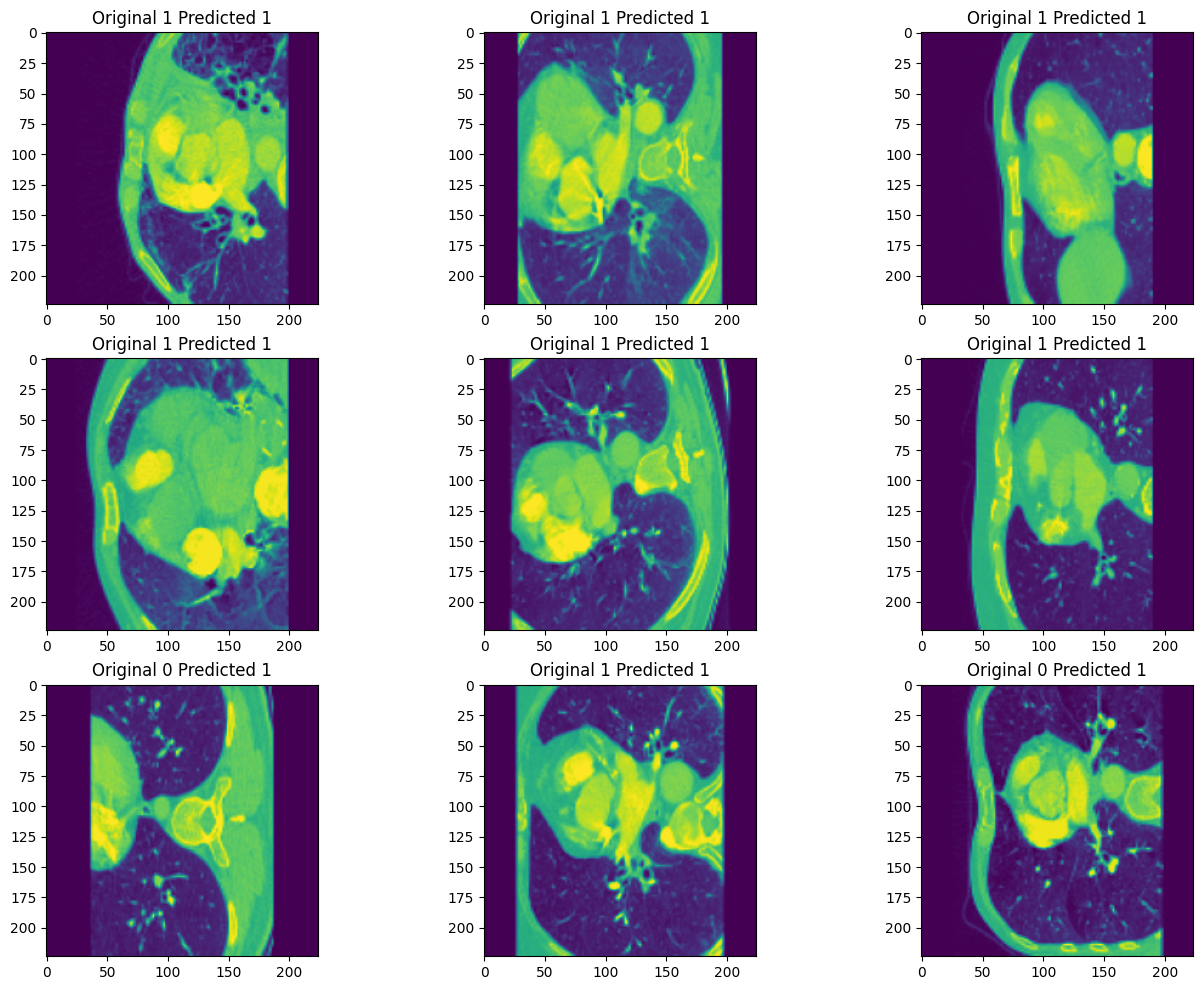

In [ ]:
#Testing
output_list = []
## Loadingn Newly trained model
model = ViT3(
    dim=1024,
    image_size=224,
    patch_size=8,
    num_classes=2,
    depth=6,
    heads=8,
    mlp_dim=2048,
    transformer=efficient_transformer,
    channels=1
).to(device)
pretrained_net = torch.load('xg_vit_model_covid_3D.pt')
model.load_state_dict(pretrained_net)


pred_labels = []
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        test_output = model(data.float())
        #print('class=',np.argmax(test_output[0].cpu(),0).item())
        cls = torch.max(test_output[0],0)
        cls = cls.indices
        pred_labels.append(np.argmax(test_output[0].cpu(),0).item())
# saving the data
        with io.open('3d16-test-output-Mar23.txt', 'a') as f:
            for i in range(len(data)):
                if cls>0:
                    f.write("%s %s\n" % (test_list[i],'1'))
                    #print("original {} pred {}".format(label,1))
                    #pred_labels.append(1)

                else:
                    f.write("%s %s\n" % (test_list[i],'0'))
                    #print("original {} pred {}".format(label,0))
                    #pred_labels.append(0)

#print(test_list)
#Working on test data
random_idx = np.random.randint(1, len(test_list),size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
#x = torch.zeros(1,1,32,224,224)
x = torch.zeros(1,1,16,224,224)
for idx, ax in enumerate(axes.ravel()):
    #img = Image.open(test_list[idx])
    #print('test-imgpath=',test_list[idx] )
    label = test_list[idx].split("-1")[-1].split("_")[-1].split(".")[-0]
    #print(type(label))
    label = 1 if label == "1" else 0
    #print(label)

    img = nibabel.load(test_list[idx])
    img = numpy.asanyarray(img.dataobj)  #struct.get_data()
    img1 = img[:,:,:,0]
    img11 = numpy.rot90(img1)
    #img = Image.open(train_list[idx])
    #ax.set_title(labels[idx])
    #print('img1-shape=',img1.shape)
    ax.imshow(img11[:,:,1])
    img2 = torch.tensor(np.array(img))
    #print('img2=', img2.shape)
    img2 = img2.permute(3,2,0,1)
    x[0]=img2
    #print('x[0][0]=', x.size())
    #print('img-name=,', test_list[idx])
    #print('img1=',img1.shape)
    #img2 = TF.to_tensor(img1)
    #print('img2-shape=',img2.shape)
    #img2 = resize2d(img1,(224,224))
    #x = torch.zeros(1,3,224,224)
    #x[0] = img2
    out = img2.float()
    out.unsqueeze_(0)
    out = out.to('cuda:0')
    model.to('cuda:0')
    # out.to(device)
    preds = model(out)
    #print('class=',torch.max(preds[0],0))
    #print("argmax {}".format(torch.argmax(preds)))
    #cls = torch.max(preds[0],0)
    #cls = cls.indices
    cls = np.argmax(test_output[0].cpu(),0).item()

    if cls==0:
        #labels[idx] = 'Covid'
        output_list.append(f'Original {label} Predicted {cls}')
    else:
        #labels[idx] = 'nonCovid'
        output_list.append(f'Original {label} Predicted {cls}')

    labels = tuple(output_list)
    #print(labels)
    with io.open('3d16-test-output-9-Mar23.txt', 'a') as f:
        f.write("%s %s\n" % (test_list[idx], label))
    ax.set_title(labels[idx])

In [ ]:
fun_classification_report(test_labels, pred_labels)

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.28      0.36        18
           1       0.82      0.92      0.87        65

    accuracy                           0.78        83
   macro avg       0.66      0.60      0.61        83
weighted avg       0.75      0.78      0.76        83



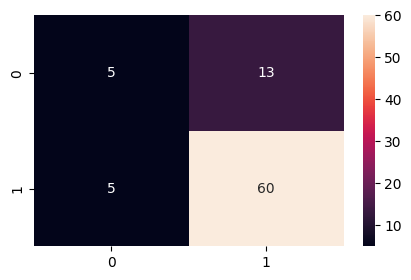

In [ ]:
fun_confusion_matrix(test_labels, pred_labels)

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_labels, pred_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.600427


In [ ]:
!pwd

/content/COVID-ViT/vit_pytorch
